In [1]:
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import re
import nbimporter

from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.tree import export_graphviz 
from sklearn.model_selection import RandomizedSearchCV
from operator import itemgetter
from exploratory_analysis import load_obj, returnDataOnDate

np.set_printoptions(precision=2)
plt.style.use('fivethirtyeight')

In [2]:
trainUnfiltered = pd.read_csv('data/training_data.csv')

In [3]:
trainUnfiltered.InsiderName = trainUnfiltered.InsiderName.str.replace("'", " ", regex=True) # names like O'Brien

def fixTitle(title):
    '''
    I figure that the Chair of the Board is the most fiscally powerful person in a company, so to break ties for
    people who hold multiple titles, I'll prioritize COB, then C-suite, then other directors, then anyone else.
    '''
    
    directorKeywords = ['Dir', 'VP', 'Vice', 'V.P.', 'Pres']
    officerKeywords = ['CEO', 'C.E.O' 'COO', 'C.O.O', 'CHRO', 'C.H.R.O', 'CFO', 'C.F.O', 'CTO', 'C.T.O', 'Chief']
    chairKeywords = ['COB', 'C.O.B.', 'Chair']
    
    if any([re.search(s, title, re.IGNORECASE) for s in chairKeywords]):
        newTitle = 'Chair'
    elif any([re.search(s, title, re.IGNORECASE) for s in officerKeywords]):
        newTitle = 'Officer'
    elif any([re.search(s, title, re.IGNORECASE) for s in directorKeywords]):
        newTitle = 'Director'
    else:
        newTitle = 'Other'
        
    return newTitle

trainUnfiltered.Title = [fixTitle(r) for r in trainUnfiltered.Title]
trainUnfiltered.head()

,Unnamed: 0,FilingDate,TradeDate,Ticker,CompanyName,InsiderName,Title,TradeType,Price,Qty,Owned,DeltaOwn,Value,NumTrades,TradeToFileTime,ValueOwned,%VolumeChange,%FuturePriceChange
0,0,2021-06-01,2021-05-27,CMBM,Cambium Networks Corp,Rau Sally,Other,S - Sale,58.60,-4938.0,0.0,-100.0,-289353.0,0,0,0.0,0.0,0.0
1,1,2021-06-01,2021-05-27,TNET,"Trinet Group, Inc.",Chamberlain Paul Edward,Director,S - Sale,77.73,-175.0,36185.0,0.0,-13603.0,0,0,0.0,0.0,0.0
2,2,2021-06-01,2021-05-27,PANL,Pangaea Logistics Solutions Ltd.,"Pangaea One Acquisition Holdings Xiv, LLC",Other,S - Sale,4.21,-184466.0,6788742.0,-3.0,-775965.0,0,0,0.0,0.0,0.0
3,3,2021-06-01,2021-05-27,TALO,Talos Energy Inc.,"Apollo Management Holdings Gp, LLC",Other,S - Sale,14.10,-81942.0,18808537.0,0.0,-1155620.0,0,0,0.0,0.0,0.0
4,4,2021-06-01,2019-07-18,CLXT,"Calyxt, Inc.",Dumont Philippe,Director,S - Sale,10.00,-706.0,16354.0,-4.0,-7060.0,0,0,0.0,0.0,0.0


In [4]:
trainUnfiltered['FilingDate'] = pd.to_datetime(trainUnfiltered['FilingDate']).dt.date
trainUnfiltered = trainUnfiltered.astype({'Price': 'float', 'Qty': 'float', 'Owned': 'float', 
                                                'DeltaOwn': 'float', 'Value': 'float', 'NumTrades': 'int', 
                                                'TradeToFileTime': 'int', '%VolumeChange': 'float', 
                                                '%FuturePriceChange': 'float'})

## XGBoost
Why choose XGBoost instead of a random forest: https://medium.com/geekculture/xgboost-versus-random-forest-898e42870f30
A great reference for tuning xgboost:
https://towardsdatascience.com/from-zero-to-hero-in-xgboost-tuning-e48b59bfaf58

In [5]:
trainDays = pd.date_range(start='2021-06-02', end='2021-06-26').date
cvDays = pd.date_range(start='2021-06-27', end='2021-06-30').date

trainUnfiltered.drop(columns=['Unnamed: 0', 'CompanyName', 'TradeDate', 'InsiderName'], 
                          inplace=True)
trainUnfiltered.head()

,FilingDate,Ticker,Title,TradeType,Price,Qty,Owned,DeltaOwn,Value,NumTrades,TradeToFileTime,ValueOwned,%VolumeChange,%FuturePriceChange
0,2021-06-01,CMBM,Other,S - Sale,58.60,-4938.0,0.0,-100.0,-289353.0,0,0,0.0,0.0,0.0
1,2021-06-01,TNET,Director,S - Sale,77.73,-175.0,36185.0,0.0,-13603.0,0,0,0.0,0.0,0.0
2,2021-06-01,PANL,Other,S - Sale,4.21,-184466.0,6788742.0,-3.0,-775965.0,0,0,0.0,0.0,0.0
3,2021-06-01,TALO,Other,S - Sale,14.10,-81942.0,18808537.0,0.0,-1155620.0,0,0,0.0,0.0,0.0
4,2021-06-01,CLXT,Director,S - Sale,10.00,-706.0,16354.0,-4.0,-7060.0,0,0,0.0,0.0,0.0


In [6]:
# Making train and cv sets
dummies_data = pd.get_dummies(trainUnfiltered, columns=['Title', 'TradeType'], prefix=['Title', None])

train_XY = dummies_data[dummies_data['FilingDate'].isin(trainDays)]
train_XY.dropna(inplace=True)
train_X = train_XY.drop(columns=['FilingDate', '%FuturePriceChange', 'Ticker'])
train_Y = train_XY['%FuturePriceChange']

assert np.any(np.isnan(train_X)) == False
assert np.all(np.isfinite(train_X)) == True
assert np.any(np.isnan(train_Y)) == False
assert np.all(np.isfinite(train_Y)) == True

cv_XY = dummies_data[dummies_data['FilingDate'].isin(cvDays)]
cv_XY.dropna(inplace=True)
cv_X = cv_XY.drop(columns=['FilingDate', '%FuturePriceChange', 'Ticker'])
cv_Y = cv_XY['%FuturePriceChange']

assert np.any(np.isnan(cv_X)) == False
assert np.all(np.isfinite(cv_X)) == True
assert np.any(np.isnan(cv_Y)) == False
assert np.all(np.isfinite(cv_Y)) == True

<ipython-input-6-4f38210aadb2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_XY.dropna(inplace=True)
<ipython-input-6-4f38210aadb2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_XY.dropna(inplace=True)


In [7]:
print(f'train shape: {train_X.shape}')
print(f'cv shape: {cv_X.shape}')

train shape: (4709, 16)
cv shape: (524, 16)


In [8]:
xgb_clf = xgb.XGBRegressor()

xgb_model = xgb_clf.fit(train_X, train_Y)

train_Y_preds = xgb_model.predict(train_X)
cv_Y_preds = xgb_model.predict(cv_X)

print('train MSE: ', mean_squared_error(train_Y, train_Y_preds))
print('cv MSE: ', mean_squared_error(cv_Y, cv_Y_preds))

train MSE:  32.38565877859326
cv MSE:  615.7043185356816


### **Well, that difference between train and cv MSE isn't good.** 

We have clearly overfit the training set. 

Let's see if tuning the hyperparameters helps cv performance:

In [9]:
xgb_clf = xgb.XGBRegressor(verbosity=1)
# Create parameter grid
parameters = {'learning_rate': [0.01, 1e-3, 1e-4],  # smaller = more conservative
              'min_split_loss' : [0, 0.1, 0.5, 1.0],  # larger = more conservative
              'max_depth': [3, 4, 5, 6, 7],  # default 6 seemed to overfit
              'max_delta_step': [0., 1., 2.],  # can help with imbalanced classes (e.g. more buys than sells)
              'colsample_bytree': [0.3, 0.6, 0.8, 1.0],
              'subsample': [0.4, 0.5, 0.6, 0.7],  # lower values should help with overfitting
              'reg_lambda': [1., 10., 100.],  # regularization controls overfitting
              'min_child_weight': [1., 3., 5.],
              'n_estimators': [100, 250, 500, 1000]}

# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(
    xgb_clf, 
    param_distributions=parameters, 
    verbose=1, 
    random_state=40
)

# Fit the model
xgb_model_tuned = xgb_rscv.fit(train_X, train_Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [10]:
itemgetter(
    'learning_rate', 'min_split_loss', 'max_depth', 'max_delta_step', 'colsample_bytree', 'subsample', 
    'reg_lambda', 'min_child_weight', 'n_estimators'
)(xgb_model_tuned.best_estimator_.get_params())

(0.01, 0.5, 4, 0.0, 1.0, 0.6, 10.0, 1.0, 250)

The biggest thing that stands out is our previous learning rate of 1 was way too high.

In [11]:
train_Y_preds_tuned = xgb_model_tuned.predict(train_X)
cv_Y_preds_tuned = xgb_model_tuned.predict(cv_X)

print('train MSE: ', mean_squared_error(train_Y, train_Y_preds_tuned))
print('cv MSE: ', mean_squared_error(cv_Y, cv_Y_preds_tuned))

train MSE:  403.7246728507264
cv MSE:  561.5666665022977


### Let's visualize our predictions vs. the actual price percentage increase:

In [12]:
dfCV_tuned = pd.DataFrame(data={'cvPreds': cv_Y_preds_tuned, 'cvVals': cv_Y})
dfCV_tuned.head(10)

,cvPreds,cvVals
4938,21.559929,57.142857
4939,11.529881,9.297821
4940,11.885159,-1.503758
4941,21.957354,26.528409
4942,9.824942,-1.304511
4943,13.147381,26.528409
4944,13.217642,26.528409
4945,9.606215,-0.502828
4946,16.233692,2.502825
4947,11.870987,14.172643


### Many of our predictions are overestimates.

That's not good: we don't want to be confident that a stock will gain a lot, only for it to underperform! On the contrary, if a stock outperforms our expectations and we've bought into it at all, then that's great!

Let's define a custom objective function that penalizes overestimates more heavily than underestimates. It will be an asymmetric mean squared error where we penalize overestimates 100 times more than underestimates. We want to be ***really*** confident that a ticker will run!

In [13]:
from typing import Tuple

def asymmetric_obj(wgt: float):
    def custom_obj(train: np.ndarray, predt: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        '''Custom objective that penalizes overestimates more heavily if wgt > 1, and underestimates if 0 < wgt < 1.
        f(train-predt) = {wgt/2*(train-predt)^2: train < predt; 1/2*(train-predt)^2: train >= predt}
        '''
        grad = -wgt*(train-predt)*(train<predt).astype(float) - (train-predt)*(train>=predt).astype(float)
        hess = wgt*(train<predt).astype(float) + (train>=predt).astype(float)
        
        return grad, hess
    return custom_obj

In [14]:
UNDERESTIMATE_BIAS = 100.

xgb_clf = xgb.XGBRegressor(verbosity=1, objective=asymmetric_obj(UNDERESTIMATE_BIAS), learning_rate=0.01)

xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions=parameters, verbose=1, random_state=40)

xgb_model_custom = xgb_rscv.fit(train_X, train_Y)
print()
print(f'''Best learning_rate, min_split_loss, max_depth, max_delta_step, colsample_bytree, subsample,
      reg_lambda, min_child_weight, n_estimators: 
      {itemgetter(
        'learning_rate', 'min_split_loss', 'max_depth', 'max_delta_step', 'colsample_bytree', 'subsample', 
        'reg_lambda', 'min_child_weight', 'n_estimators'
       )(xgb_model_custom.best_estimator_.get_params())
      }''')

train_Y_preds_custom = xgb_model_custom.predict(train_X)
cv_Y_preds_custom = xgb_model_custom.predict(cv_X)

#d2 = {'TrainPreds': train_Y_preds_custom, 'TrainVals': train_Y}
#dfTrain = pd.DataFrame(data=d2)
#print(dfTrain.head(15))

print()
print('train MSE: ', mean_squared_error(train_Y, train_Y_preds_custom))
print('cv MSE: ', mean_squared_error(cv_Y, cv_Y_preds_custom))

dfCV_custom = pd.DataFrame(data={'cvPreds': cv_Y_preds_custom, 'cvVals': cv_Y})

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best learning_rate, min_split_loss, max_depth, max_delta_step, colsample_bytree, subsample,
      reg_lambda, min_child_weight, n_estimators: 
      (0.01, 0.1, 7, 0.0, 0.8, 0.6, 1.0, 5.0, 100)

train MSE:  630.6133429505602
cv MSE:  692.0159785579315


In [16]:
print(f'''Average difference between predicted and actual changes: 
        {np.mean(cv_Y_preds_custom-cv_Y.to_numpy())}%\n''')

Average difference between predicted and actual changes: 
        -11.406552154924626%



In [17]:
SP500_90DAY_GAIN = round(100*(451.81-419.63)/419.63)  # = 8 percent

labels = ['<0% (Loss)', 
          f'0-{round(0.5*SP500_90DAY_GAIN)}% (0-0.5x S&P)',
          f'{round(0.5*SP500_90DAY_GAIN)}-{SP500_90DAY_GAIN}% (0.5-1x S&P)',
          f'{SP500_90DAY_GAIN}-{2*SP500_90DAY_GAIN}% (1-2x S&P)',
          f'>{2*SP500_90DAY_GAIN}% (>2x S&P)']

def returnPriceLabels(priceChange):
    if priceChange < 0:
        return labels[0]
    elif priceChange >= 0 and priceChange < round(0.5*SP500_90DAY_GAIN):
        return labels[1]
    elif priceChange >= round(0.5*SP500_90DAY_GAIN) and priceChange < SP500_90DAY_GAIN:
        return labels[2]
    elif priceChange >= SP500_90DAY_GAIN and priceChange < 2*SP500_90DAY_GAIN:
        return labels[3]
    else:
        return labels[4]

pred_labels = [returnPriceLabels(r) for r in cv_Y_preds_custom]
true_labels = [returnPriceLabels(r) for r in cv_Y.to_numpy()]

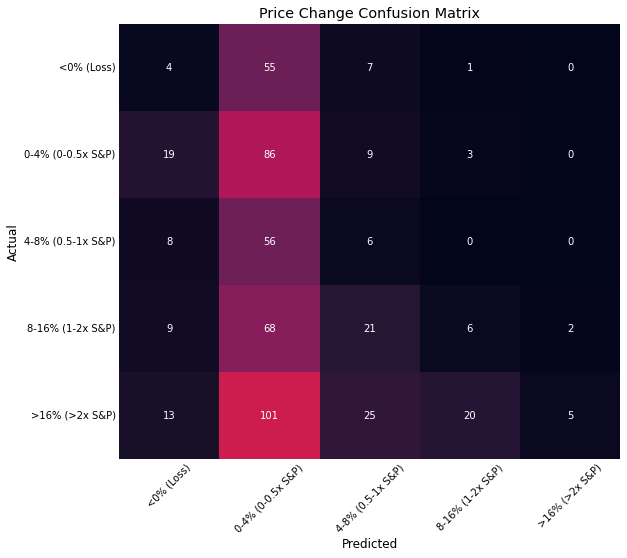

In [18]:
import seaborn as sn

confMat = metrics.confusion_matrix(true_labels, pred_labels, labels=labels)
plt.figure(figsize = (8,8))
sn.heatmap(pd.DataFrame(confMat, labels, labels), annot=True, fmt='g', cbar=False, vmin=0, vmax=200)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.title('Price Change Confusion Matrix')
plt.show()

In [19]:
xgb_clf = xgb.XGBRegressor(**xgb_model_custom.best_estimator_.get_params())

xgb_model_final = xgb_clf.fit(train_X, train_Y)

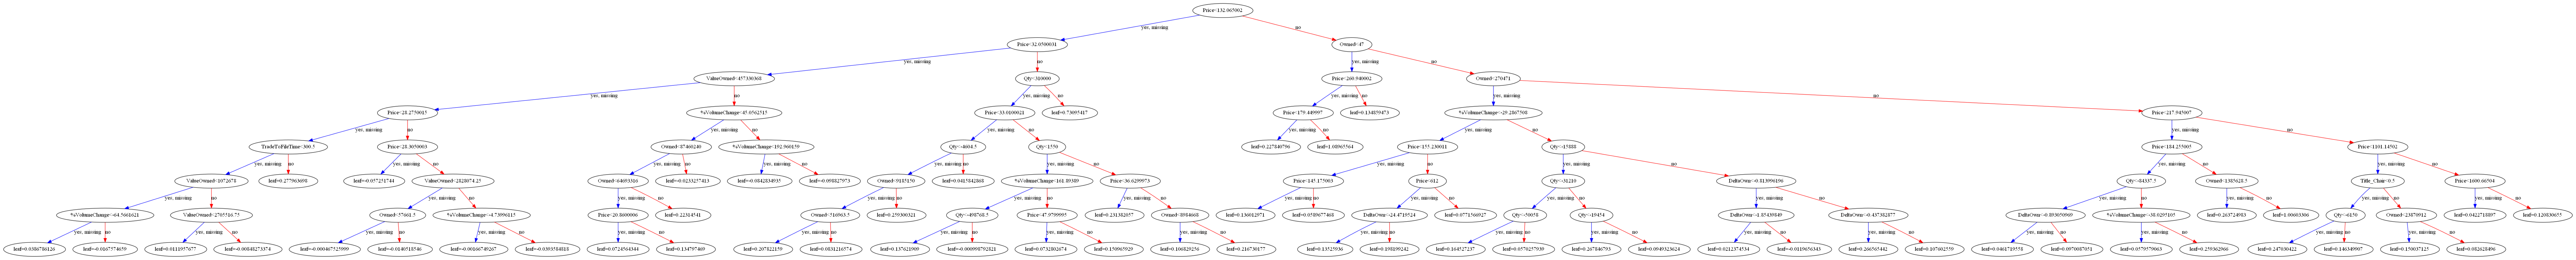

In [20]:
# Graphviz isn't on the environment's path by default, for some reason
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

_ = xgb.plot_tree(xgb_model_final)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()
fig.savefig('outputs/regression_tree.png')

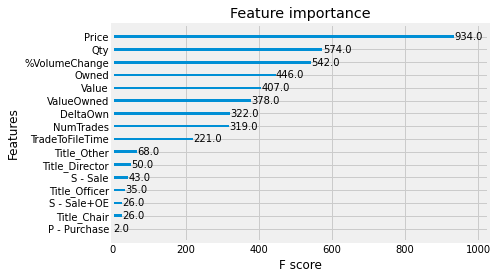

In [21]:
_ = xgb.plot_importance(xgb_model_final)
plt.show()

## Strategy

I'm a total noob in this area, and I'm not afraid to admit it! Luckily, designing a foolproof investment strategy wasn't the point of this project. The point was to see if we've learned to identify which insider trades are worth paying attention to!


However, in the interest of clearly demonstrating what has been learned, let's define a REALLY simple strategy:
- Knowing that our algorithm is conservative, we'll only put faith in high predictions: If an insider trade is filed that our algorithm predicts will rise by >10\%, purchase \\$1 at the next day's opening.
- If, in the next 90 days, the value of our purchase is at least 15\% higher at any closing, immediately sell. (Our algorithm is conservative enough that we've decided to be greedy, hoping to squeeze out a bit more gain than predicted.)

This strategy, of course, assumes that we successfully make each purchase right at the opening and each sell right at the closing.

In [22]:
cv_XY_preds = cv_XY.copy()
cv_XY_preds['Prediction'] = cv_Y_preds_custom

In [23]:
historicDat = load_obj('historicDat')

In [44]:
startDate = '2021-06-27'
endDate = '2021-09-27'
buyThresh = 10
sellThresh = 15

purchasesDict = {}
totalInvested = 0
totalProfit = 0

for d in pd.date_range(start=startDate, end=endDate):    
    currentDate = dt.date.strftime(d.date(), '%Y-%m-%d')
    
    for tradeNum, trade in cv_XY_preds[cv_XY_preds['FilingDate'] == d.date()].iterrows():
        # Check prediction. If high enough, purchase at next day's opening.
        if trade['Prediction'] < buyThresh:
            continue
        
        tick = trade['Ticker']
        
        buyPrice, buyDate = returnDataOnDate(historicDat, tick, currentDate, delta=1, dataName='Open')
        buyDate = dt.date.strftime(buyDate, '%Y-%m-%d')
        
        totalInvested += 1
        
        print(f'''Buying {tick} on {buyDate}, currently ${round(buyPrice, 2)}''')
        
        if tick in purchasesDict.keys():
            purchasesDict[tick]['BuyPrice'].append(buyPrice)
            purchasesDict[tick]['SellPrice'].append(None)
        else:
            purchasesDict[tick] = {'BuyPrice': [buyPrice], 'SellPrice': [None]}
        

    # Check current already-purchased stocks. If value has risen enough, sell at closing.
    for tick, elem in purchasesDict.items():
        for buyNum, buyPrice in enumerate(elem['BuyPrice']):
            try:
                currentPrice = historicDat[tick].loc[currentDate]['Close']
                if (currentPrice > (1. + sellThresh/100)*buyPrice) and (elem['SellPrice'][buyNum] is None):
                    elem['SellPrice'][buyNum] = currentPrice
                    profit = (currentPrice-buyPrice) / buyPrice
                    totalProfit += profit
                    print(f'''Selling {tick} on {currentDate}, currently ${round(currentPrice, 2)}, a {round(100*profit, 2)}% profit''')
                    
            except KeyError:
                pass  # unable to sell on this day; move on
        
        # sell everything that hasn't already been sold on the last day
        if d.date() == dt.datetime.strptime(endDate, '%Y-%m-%d').date():
            elem['SellPrice'] = [currentPrice if val is None else val for val in elem['SellPrice']]


print('\n-----------------------------------------\n')

'''Determine total profit in the given time period.'''
print(f'''We invested ${totalInvested} and earned ${round(totalProfit, 2)} for a return of \
{round(100*totalProfit/totalInvested, 2)}%.''')

Buying BILL on 2021-06-29, currently $187.0
Buying ASAN on 2021-06-29, currently $63.15
Buying TRVN on 2021-06-29, currently $1.86
Buying GMS on 2021-06-29, currently $49.4
Buying CVNA on 2021-06-29, currently $301.63
Buying CVNA on 2021-06-29, currently $301.63
Buying CVNA on 2021-06-29, currently $301.63
Buying ZI on 2021-06-30, currently $53.0
Buying ZI on 2021-06-30, currently $53.0
Buying CVNA on 2021-06-30, currently $301.67
Buying UHAL on 2021-06-30, currently $587.37
Buying TLRS on 2021-06-30, currently $0.22
Buying ZI on 2021-06-30, currently $53.0
Buying ZI on 2021-06-30, currently $53.0
Buying CVNA on 2021-07-01, currently $300.0
Buying ZI on 2021-07-01, currently $52.0
Buying ZI on 2021-07-01, currently $52.0
Buying ZI on 2021-07-01, currently $52.0
Buying ZI on 2021-07-01, currently $52.0
Buying KOD on 2021-07-01, currently $95.05
Buying ZI on 2021-07-01, currently $52.0
Buying ASAN on 2021-07-01, currently $63.18
Buying ZI on 2021-07-01, currently $52.0
Buying ETSY on 202